# Usual adjoint vs. holes adjoint

We will compare a free-form optimized power splitter to an optimization using only hole parameters.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy

# add angler to path (not necessary if pip installed)
import sys
sys.path.append("..")

# import the main simulation and optimization classes
from angler import Simulation, Optimization

# import some structure generators
from angler.structures import three_port, two_port

%load_ext autoreload
%autoreload 2
%matplotlib inline

Define some of the parameters we'll be using in our optimization

In [2]:
# define the similation constants
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.4e-1                   # grid size (L0)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1e-9           # amplitude of modal source (make around 1 for nonlinear effects)

In [3]:
# define material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity

In [4]:
# geometric parameters for a 1 -> 2 port device
L = 6         # length of box (L0)
H = 4         # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/1.5     # distance between waveguides (L0)
l = 3         # length of waveguide from PML to box (L0)
spc = 2       # space between box and PML (L0)

## Defining the Simulation Object
Now, we can create an initial relative permittivity, define our design region, and create the `Simulation` object for our domain.

Computed a domain with 340 grids in x and 240 grids in y
The simulation has 50 grids per free space wavelength


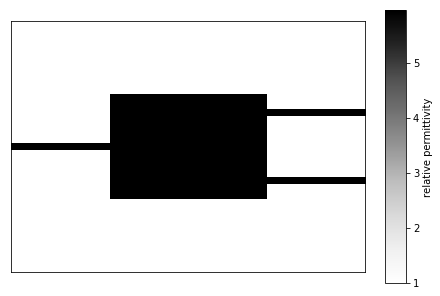

In [5]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

# make a new simulation object
simulation_base = Simulation(omega, eps_r, dl, NPML, pol)

print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation_base.L0)))

# plot the permittivity distribution
simulation_base.plt_eps(outline=False)
plt.show()

`Simulation` objects are used for running the actual FDFD simulations and we define our optimizations over them.

## Sources and Probes

With our simulation defined, we may now define the modal profiles of our input and output ports.  

We will first add a modal source to our simulation corresponding to the port on the left.

Then, we'll create two temporary simulations that are identical to the original, add modal sources for the top and bottom ports, and use these to get numpy arrays corresponding to the top and bottom probes of the device.  While in the code we are labelling these `J_top` and `J_bot`, in the paper, these are called $\mathbf{m}_{t}$ and $\mathbf{m}_b$ respectively

In [6]:
# set the input waveguide modal source
simulation_base.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[NPML[0]+int(l/2/dl), ny], width=int(H/2/dl), scale=source_amp)
simulation_base.setup_modes()

# make a new simulation to get the modal profile of the top output port
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], width=int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# make a new simulation to get the modal profile of the bottom output port
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], width=int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

Now we can use `J_top` and `J_bot` as probes in our objective function.  We'll no longer need the `top` and `bot` Simulations.

We can plot solve the simulation for the electric and magnetic fields and then plot the results.

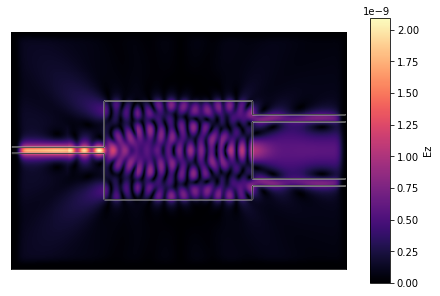

In [7]:
# set source and solve for electromagnetic fields
(Hx, Hy, Ez) = simulation_base.solve_fields()
simulation_base.plt_abs(outline=True, cbar=True);

## Normalizing

As an optional step, we'll normalize the modal amplitudes such that $|J^T E|^2 = 1$ for perfect transmission to the port corresponding to $J$.

To do this, we'll make another temporary simulation with just a straight waveguide of the same source as our original three port.

We'll then compute $|J^T E|^2$ for the output port, and normalize `J_in` and `J_out` using this. 

computed a scale of 1.243817406196961e-18


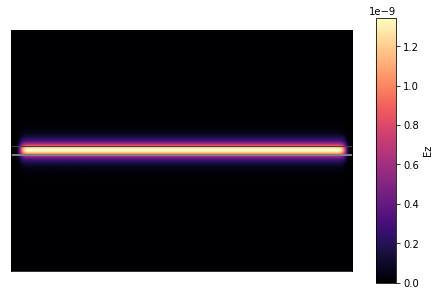

In [8]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg*J_out)))
J_out = J_out
print('computed a scale of {}'.format(SCALE))

simulation_wg.plt_abs(outline=True, cbar=True);

J_top = J_top / np.sqrt(SCALE)
J_bot = J_bot / np.sqrt(SCALE)

## Defining Objective Functions

Now is one of the most important steps: defining the objective function for optimization / inverse design.

To do this, we define a function `J` which takes in the linear fields as the first argument and the nonlinear fields as a second argument.

Until we make this more flexible, if your problem is linear, you still need the nonlinear fields argument, but you dont have to use it within the body of the function. 

We require that you define your numpy operations within J using the autograd wrapper for numpy.

This allows us to automatically compute the partial derivatives of $J$ w.r.t. $E$ and $E_{nl}$, which are used in the adjoint.  

This is super helpful when you define complicated objective functions and dont feel like computing these by hand!

Below is an example of an objective function where the top and bottom port transmissions are directly multiplied.

`angler` will try to maximize `J` w.r.t the permittivity in the design region.  Since we're multiplying the transmissions here, a highest possible value of `J = 1` will occur when each port is at 50% transmission, which is what we want.

In [9]:
# define objective function  (equal power transmission to bottom and top)
import autograd.numpy as npa
from angler.objective import Objective, obj_arg

arg1 = obj_arg('ez', component='Ez', nl=False)

def J(ez):
    linear_top =     1*npa.sum(npa.square(npa.abs(ez*J_top)))
    linear_bot =     1*npa.sum(npa.square(npa.abs(ez*J_bot)))
    objfn = linear_top * linear_bot * 4
    return objfn

objective = Objective(J, arg_list=[arg1])

## Defining a normal adjoint optimization

Let's first try to optimize using the standard "free-form" adjoint

 ObjectiveFn:   1.34 Iteration:  99/100 ETA:   0:00:01                         

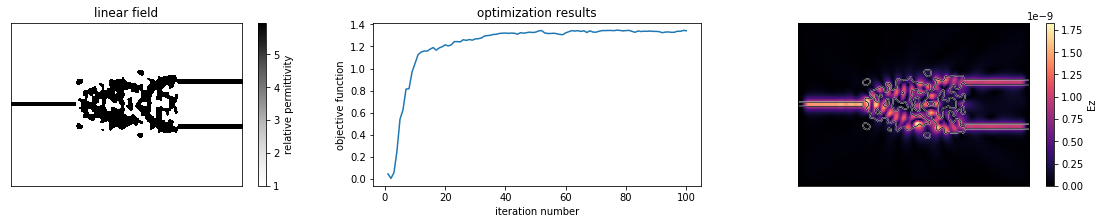

        -> linear transmission (top)        = 48.80 %
        -> linear transmission (bottom)     = 49.17 %


In [10]:
# make optimization object
simulation = copy.deepcopy(simulation_base)
simulation.init_design_region(design_region, eps_m, style='random_sym')

R = 4          # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta = 300     # projection strength
eta= 0.50      # projection halfway

optimization = Optimization(objective=objective, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)
new_eps = optimization.run(method='adam', Nsteps=100)

# plot the objective function end structure and fields
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax3, vmax=None)
ax1.set_title('linear field')

plt.show()

# plot transmission characteristics
W_in = simulation.W_in   # input power (W/um)

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

print('        -> linear transmission (top)        = {:.2f} %'.format(W_top_lin / W_in * 100))
print('        -> linear transmission (bottom)     = {:.2f} %'.format(W_bot_lin / W_in * 100))

## Now let's try optimization using holes

The gradient is computed numerically from the pixel-by-pixel gradient. See `optimization.compute_drho()`

The hole parameters are then updated in `optimization._update_holes()`. The following optional constraints have been implemented:

- fix_x : True        - Does not update the x-positions
- fix_y : True        - Does not update the y-positions
- fix_r : True        - Does not update the radii
- r_min : scalar      - Truncates the minimum radius to r_min 
- r_max : scalar      - Truncates the maximum radius to r_max
- r_rem : scalar      - Removes the hole if radius gets below r_rem
- min_dist : scalar   - Imposes a minimum separation between holes (update is not accepted otherwise)

Some things that could still be done:

- other constraints: e.g. staying inside the design region
- explore the dependence on the step in the gradient computation (currently set to `simulation.dl`) and the step in the parameter update
- implement lbfgs? Currently only adam/gd supported.

### No constraints, random starting radii

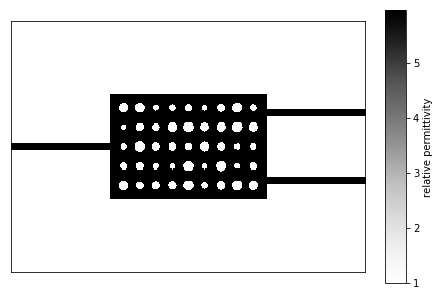

 ObjectiveFn:   1.37 Iteration:  49/50 ETA:   0:00:04                          

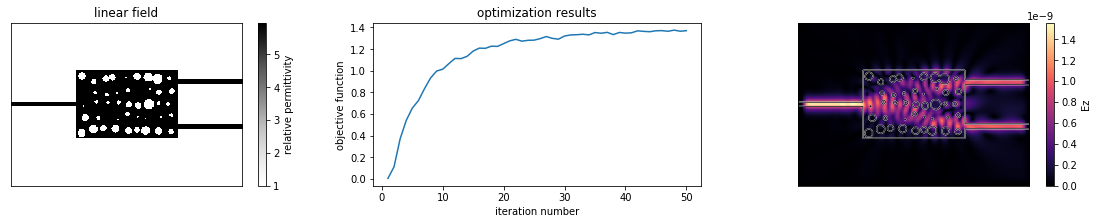

        -> linear transmission (top)        = 47.18 %
        -> linear transmission (bottom)     = 50.63 %


In [13]:
np.random.seed(2019)
simulation = copy.deepcopy(simulation_base)

# Add some holes
x = np.linspace(-2.5, 2.5, 9)
y = np.linspace(-1.5, 1.5, 5)
xs, ys = np.meshgrid(x, y)
rs = 0.1 + np.random.rand(xs.shape[0], xs.shape[1])*0.1
simulation.apply_holes(xs, ys, rs)
# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

optimization = Optimization(objective=objective, simulation=simulation, 
                            design_region=design_region, eps_m=eps_m, holes=True)
new_eps_holes = optimization.run(method='adam', Nsteps=50, step_size = 0.01)

# plot the objective function end structure and fields
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax3, vmax=None)
ax1.set_title('linear field')

plt.show()

# plot transmission characteristics
W_in = simulation.W_in   # input power (W/um)

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

print('        -> linear transmission (top)        = {:.2f} %'.format(W_top_lin / W_in * 100))
print('        -> linear transmission (bottom)     = {:.2f} %'.format(W_bot_lin / W_in * 100))

### Same starting point, minimum distance imposed

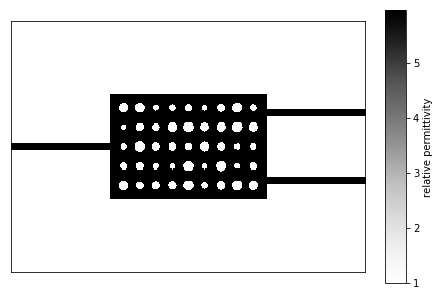

 ObjectiveFn:   1.36 Iteration:  49/50 ETA:   0:00:04                          

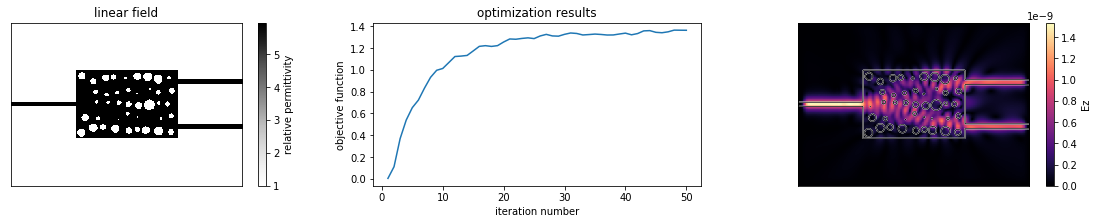

        -> linear transmission (top)        = 49.68 %
        -> linear transmission (bottom)     = 48.28 %


In [15]:
np.random.seed(2019)
simulation = copy.deepcopy(simulation_base)

# Add some holes
x = np.linspace(-2.5, 2.5, 9)
y = np.linspace(-1.5, 1.5, 5)
xs, ys = np.meshgrid(x, y)
rs = 0.1 + np.random.rand(xs.shape[0], xs.shape[1])*0.1
simulation.apply_holes(xs, ys, rs)
# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

optimization = Optimization(objective=objective, simulation=simulation, 
                            design_region=design_region, eps_m=eps_m, holes=True,
                               holes_constraints = {'min_dist': 0.1})
new_eps_holes = optimization.run(method='adam', Nsteps=50, step_size = 0.01)

# plot the objective function end structure and fields
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax3, vmax=None)
ax1.set_title('linear field')

plt.show()

# plot transmission characteristics
W_in = simulation.W_in   # input power (W/um)

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

print('        -> linear transmission (top)        = {:.2f} %'.format(W_top_lin / W_in * 100))
print('        -> linear transmission (bottom)     = {:.2f} %'.format(W_bot_lin / W_in * 100))

### Same starting point, minimum distance imposed and only radii changed

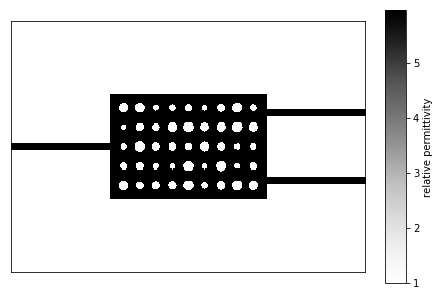

 ObjectiveFn:   1.16 Iteration:  49/50 ETA:   0:00:04                          

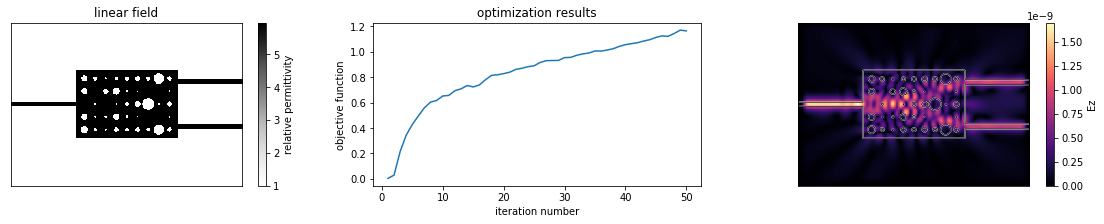

        -> linear transmission (top)        = 46.80 %
        -> linear transmission (bottom)     = 44.00 %


In [17]:
np.random.seed(2019)
simulation = copy.deepcopy(simulation_base)

# Add some holes
x = np.linspace(-2.5, 2.5, 9)
y = np.linspace(-1.5, 1.5, 5)
xs, ys = np.meshgrid(x, y)
rs = 0.1 + np.random.rand(xs.shape[0], xs.shape[1])*0.1
simulation.apply_holes(xs, ys, rs)
# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

optimization = Optimization(objective=objective, simulation=simulation, 
                            design_region=design_region, eps_m=eps_m, holes=True,
                               holes_constraints = {'min_dist': 0.1, 'fix_x':True, 'fix_y':True})
new_eps_holes = optimization.run(method='adam', Nsteps=50, step_size = 0.01)

# plot the objective function end structure and fields
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax3, vmax=None)
ax1.set_title('linear field')

plt.show()

# plot transmission characteristics
W_in = simulation.W_in   # input power (W/um)

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

print('        -> linear transmission (top)        = {:.2f} %'.format(W_top_lin / W_in * 100))
print('        -> linear transmission (bottom)     = {:.2f} %'.format(W_bot_lin / W_in * 100))

### Constant radius, minimum distance imposed and only positions changed

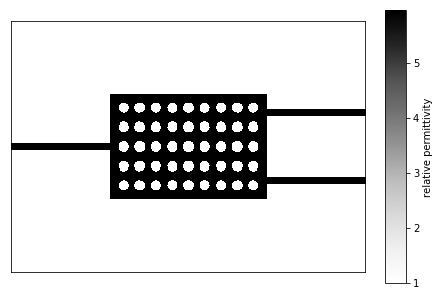

 ObjectiveFn:   1.28 Iteration:  49/50 ETA:   0:00:04                          

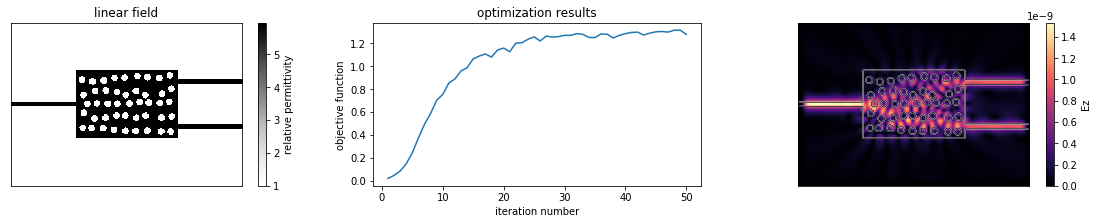

        -> linear transmission (top)        = 47.85 %
        -> linear transmission (bottom)     = 49.34 %


In [20]:
np.random.seed(2019)
simulation = copy.deepcopy(simulation_base)

# Add some holes
x = np.linspace(-2.5, 2.5, 9)
y = np.linspace(-1.5, 1.5, 5)
xs, ys = np.meshgrid(x, y)
rs = 0.2*np.ones(xs.shape)
simulation.apply_holes(xs, ys, rs)
# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

optimization = Optimization(objective=objective, simulation=simulation, 
                            design_region=design_region, eps_m=eps_m, holes=True,
                               holes_constraints = {'min_dist': 0.1, 'fix_r':True})
new_eps_holes = optimization.run(method='adam', Nsteps=50, step_size = 0.01)

# plot the objective function end structure and fields
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax3, vmax=None)
ax1.set_title('linear field')

plt.show()

# plot transmission characteristics
W_in = simulation.W_in   # input power (W/um)

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

print('        -> linear transmission (top)        = {:.2f} %'.format(W_top_lin / W_in * 100))
print('        -> linear transmission (bottom)     = {:.2f} %'.format(W_bot_lin / W_in * 100))

## Conclusions

- For this particular problem, optimizing hole positions/radii works as well as the free-form design, and fabrication constraints are more straightforward to impose.

- Even optimizing the hole positions only and keeping the same hole radius everywhere works. This could be good news for fabrication.

- There are obviusly many, many more tests that could be done...

- Note that a "good" starting structure is probably very important. The number of holes can only decrease if the radius becomes very small (or if `r_rem` constraint is applied), but new holes cannot be created. 

- It would also be good to see how this fares on a harder problem. I briefly tried it on the nonlinear T-port optimization and it did not work well, but we know that the nonlinear stuff is very unstable. I would say the best thing to do is to test it on an interesting linear optimization.